# 机器学习的目标

第 4 章的 3 个例子,尽管互相从模型到输入都有一定差别,但是无一例外,没当经过几个轮次后,模型就开始过拟合.在测试集上效果开始变差.

模型的泛化与优化是机器学习的根本矛盾,而过拟合是如何产生的?如何得到泛化性能更好的模型?


## 理解过拟合

在所有能见到的模型和数据集上,都会存在过拟合问题,随着训练进行,模型在训练集上表现越来越好,但是超过一定程度模型在测试集上表现反而开始变差.如下图.

![typical_overfitting](./typical_overfitting.png)

训练刚刚开始,模型的泛化能力和训练轮次是正相关的.此时模型是欠拟合状态.模型还没有从训练集很好的学习到普遍规律.当训练继续进行,模型已经习得了这一类数据的普遍规律,但是训练还在继续,之后模型开始学习到的可能就是训练集专有的特征.于是在前所未见的测试集上,模型的效果开始越来越差.即过拟合了.

## 噪声数据

现实世界的数据集有相当部分可能是无效输入.

mnist 数据集的例子

- 无效的数据 ![fucked_up_mnist](./fucked_up_mnist.png)
- 标注错误的数据 ![mislabeled_mnist.png](./mislabeled_mnist.png)

当这些数据被用在训练集时,训练后期模型开始学习这些异常值的特征,此时模型的泛化性能开始下降.

![outliers_and_overfitting](./outliers_and_overfitting.png)


## 模糊数据

并非所有的是不准确数据都是来自噪声.特别是涉及到不确定和模糊性问题时.

- 分类植物果实成熟/不成熟.这个分类本身就带有主观性.
- 气象条件预测明天天气,即使相同的气象条件,明天下雨不下雨都有可能.

过度学习模糊数据,就会导致过拟合.更好的办法是忽略模糊地带,更着眼在大局上.

![overfitting_with_uncertainty](./overfitting_with_uncertainty.png)


## 罕见数据

如果你一生只见过两只虎皮猫,碰巧它们脾气都很坏,那你可能会得出虎皮猫脾气都很坏的结论.

~~从经历/经验/学习中总结规律,这些规律构成了人的认知.遇到错误/罕见/异常数据,人可以主观过滤/忽略/寻找异常原因.但是目前的机器学习做不到.大概是因为没有自我的概念??~~以上是我胡诌,请忽略.

重点是罕见数据只出现几次就可能导致模型学习到错误的特征,但是模型完成了任务,错的是准备数据的人.


In [1]:
from tensorflow.keras.datasets import mnist
import numpy as np

(train_images, train_labels), _ = mnist.load_data()
train_images = train_images.reshape((60000, 28 * 28))
train_images = train_images.astype("float32") / 255

train_images_with_noise_channels = np.concatenate(
    [train_images, np.random.random((len(train_images), 784))], axis=1)  #随机白噪声

train_images_with_zeros_channels = np.concatenate(
    [train_images, np.zeros((len(train_images), 784))], axis=1)  #全0


创建了 784 个白噪声数据插入数据集.同时添加一组全0,做对比


In [2]:
from tensorflow import keras
from tensorflow.keras import layers


def get_model():
    model = keras.Sequential([
        layers.Dense(512, activation="relu"),
        layers.Dense(10, activation="softmax")
    ])
    model.compile(optimizer="rmsprop",
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])
    return model


model = get_model()
history_noise = model.fit(
    train_images_with_noise_channels,
    train_labels,  #噪音样本
    epochs=10,
    batch_size=128,
    validation_split=0.2)

model = get_model()
history_zeros = model.fit(
    train_images_with_zeros_channels,
    train_labels,  #全0样本
    epochs=10,
    batch_size=128,
    validation_split=0.2)

Epoch 1/10
375/375 [==============================] - 3s 5ms/step - loss: 0.6247 - accuracy: 0.8116 - val_loss: 0.2839 - val_accuracy: 0.9093
Epoch 2/10
375/375 [==============================] - 2s 4ms/step - loss: 0.2475 - accuracy: 0.9227 - val_loss: 0.2111 - val_accuracy: 0.9367
Epoch 3/10
375/375 [==============================] - 2s 4ms/step - loss: 0.1619 - accuracy: 0.9498 - val_loss: 0.1782 - val_accuracy: 0.9461
Epoch 4/10
375/375 [==============================] - 2s 4ms/step - loss: 0.1134 - accuracy: 0.9642 - val_loss: 0.1322 - val_accuracy: 0.9619
Epoch 5/10
375/375 [==============================] - 2s 5ms/step - loss: 0.0836 - accuracy: 0.9733 - val_loss: 0.1216 - val_accuracy: 0.9656
Epoch 6/10
375/375 [==============================] - 2s 4ms/step - loss: 0.0625 - accuracy: 0.9800 - val_loss: 0.1423 - val_accuracy: 0.9581
Epoch 7/10
375/375 [==============================] - 2s 4ms/step - loss: 0.0463 - accuracy: 0.9853 - val_loss: 0.1414 - val_accuracy: 0.9619
Epoch 

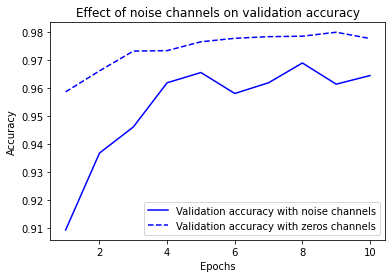

In [3]:
import matplotlib.pyplot as plt
val_acc_noise = history_noise.history["val_accuracy"]
val_acc_zeros = history_zeros.history["val_accuracy"]
epochs = range(1, 11)
plt.plot(epochs, val_acc_noise, "b-",
         label="Validation accuracy with noise channels")
plt.plot(epochs, val_acc_zeros, "b--",
         label="Validation accuracy with zeros channels")
plt.title("Effect of noise channels on validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

最终噪声大于降低了模型 1% 的精度.添加噪声越多,模型受影响越大.

如果数据用于极多的特征,一般要进行特征选择.像是 imdb 数据集只保留了前 10000 个最常见的单词.进行特征选择前主要工作是首先衡量每个特征的信息量,只保留高于某个阈值的特征.


## 深度学习的本质

只要计算能力够,深度学习可以拟合任何数据.


In [6]:
(train_images, train_labels), _ = mnist.load_data()
train_images = train_images.reshape((60000, 28 * 28))
train_images = train_images.astype("float32") / 255

random_train_labels = train_labels[:]
np.random.shuffle(random_train_labels)  #随机label

model = keras.Sequential([
    layers.Dense(512, activation="relu"),
    layers.Dense(10, activation="softmax")
])
model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
model.fit(train_images,
          random_train_labels,
          epochs=100,
          batch_size=128,
          validation_split=0.2,
          verbose=0)  #静默
history = model.history  #输出结果

In [9]:
print(history.history)

{'loss': [2.3166775703430176, 2.299060344696045, 2.2892870903015137, 2.2745916843414307, 2.256817102432251, 2.2347278594970703, 2.2102885246276855, 2.1816353797912598, 2.1515889167785645, 2.120704174041748, 2.0865683555603027, 2.0537240505218506, 2.019094944000244, 1.9845826625823975, 1.9483704566955566, 1.9148609638214111, 1.8789057731628418, 1.8446723222732544, 1.8118715286254883, 1.7781283855438232, 1.7455836534500122, 1.7138621807098389, 1.6814841032028198, 1.6522071361541748, 1.6224040985107422, 1.5932786464691162, 1.566838264465332, 1.5390281677246094, 1.5098239183425903, 1.4838279485702515, 1.458466649055481, 1.431588888168335, 1.4085923433303833, 1.382411003112793, 1.3600544929504395, 1.3375434875488281, 1.3123267889022827, 1.2908780574798584, 1.2703371047973633, 1.2488101720809937, 1.2264150381088257, 1.2064249515533447, 1.1877660751342773, 1.1685642004013062, 1.1486690044403076, 1.1312315464019775, 1.1121361255645752, 1.0929288864135742, 1.0743907690048218, 1.0568585395812988

随机生成的 label + mnist 的图片数据,训练 100 次,都能到 99%.

其实不需要 minist 的图片数据,随机生成数据,神经网络也能拟合到 99%.拟合的尽头是在这些数据上的一个字典.

so,到底深度学习/神经网络的泛化能力到底是什么?为什么对随机数据也能拟合?


## 流形假说

mnist 输入是 28*28*255 的整数阵列,这个样本空间要比宇宙的原子数还有大得多.但是实际手写数字所有可能的样本空间只是父空间一个非常小的子空间.

想象一下构建实际手写数字所有可能的样本空间

- 取 0~9 十个手写数组样本
- 0~9 这十个样本,在不改变人读取意思的情况下又产生随机变化,新的图像加入样本库.
- 在任意两个之间开始变换,中间产生的任何图像都属于这个样本空间.

这个空间内,任取一个样本都可以看作是其他两个样本变换的中间过程,这个空间是连续的.即使存在某些非常奇怪的过渡图像,但也会被人看作是数字.

![mnist_manifold](./mnist_manifold.png)

上图就是 12 章代码生成的流形.


上面实际手写数字的样本空间也被称为流形,流形是某个父空间的低维子空间.

- 二维平面的一个流形可以是一个光滑曲线.
- 三位空间的一个流形可以是一个光滑曲面.
- 以此类推.

正如手写数字的样本空间只是 28*28*255 父空间的一个非常小的部分,我们可以把它看成是父空间的一个流形.


流形假说认为所有自然数据都是它被编码的高维空间的一个低维流形.(28*28*255 父空间 -> 手写数字的样本空间).

流形假说对机器学习

- 输入数据是某个高维空间的低维流形,机器学习只在这个相对简单 低维 结构化的子空间拟合数据.
- 拟合输入的两个数据,进行插值,中间得到的全部数据理论上都在这个流形中.不断的输入新的数据,不断的拟合,模型每次能表示的流形空间的比例就越高.

神经网络的泛化能力,就来自对样本插值还原流形的过程.


## 插值是泛化能力的来源

神经网络训练时,每次输入新的样本,都会和已有的流形上其他样本关联,相当于多了流形以外的一个点,神经网络再通过插值填补这个点到流形的空白.

![linear_interpolation_vs_manifold_interpolation](./linear_interpolation_vs_manifold_interpolation.png)

注意神经网络在流形上的插值(内插?)和父空间上的线性插值是不同的概率.如上图 mnist 数据父空间的线性插值通常并不是有效数字.

最重要的是,虽然深度学习通过流形上不断输入新样本插值实现了泛化,但是这样的插值绝非泛化本身的全部.流形上插值只能用来理解相似的事物,进行局部的概况.但是人本身有能力进行极端的概括,这部分是类似插值以外的认知决定的 --> 抽象.

具体我们会在 14 章讨论.(我省略了一些内容,暂时无法理解)


## 为什么深度学习能够完成任务?

![ch02-geometric_interpretation_4](./ch02-geometric_interpretation_4.png)

如上图所示,第二章的示例图片.这张纸可以看作是三维空间的一个二维流形,深度学习模型就是解开这团纸的工具.

![the_cartoon_of_fitting.png](./the_cartoon_of_fitting.png)

深度学习模型训练的过程

- 开始是一个非常高维的平滑曲线,基本的约束来自模型的拓扑和随机化的参数.
- 这条曲线通过梯度下降平滑将近的与数据点相适应.
- 这条曲线的终点是记住了所有的训练样本.但是训练样本并不能代表整个流形,因此此时是过拟合.
- 我们真正需要的是这个过程中间的某个点,即模型的空间和流形最为接近的时刻.
- 因为输出的模型非常接近实际的数据流形,因此即使是从未见过的数据点也能够正确预测.

深度学习还有还有其他特点使得它非常适合流形的学习

- 模型的输入到输出必须是平滑连续的映射,换而言之,必须是可微的(否则无法梯度下降),流形也有类似的性质(平滑).
- 深度学习模型的拓扑往往可以反应出流形的结构.例如后面要学的图像处理模型,序列处理模型等等.神经网络分层和模块化的结构也和自然数据的组织方式类似.

## 无论如何,数据最重要

无论深度学习如何进行拟合,理论上,实践上如何解释.最终这些都是在输入的训练数据上进行.最终模型的泛化能力是训练数据的结果而不是模型本身的属性.

训练数据的信息量越大,噪音越小最终才能更好的归纳.

![dense_sampling](./dense_sampling.png)

另外深度学习进行的是曲线的拟合,样本越密集尤其是在决策边界越密集,拟合的曲线会更加接近实际的流形.

无论如何,要始终牢记,改进深度学习模型

- 更多/更好的数据
- 改进模型的结构

前者是调整深度学习模型最先需要进行,最终的步骤.模型本身的调整是在此之后.我们将在 5.4 节中详细讨论.

在调整深度学习模型之前,首先需要评估模型,这是 5.2 的主要内容.
